In [1]:
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
try:
    from visualization import (
        plot_average_stats_comparison,
        plot_total_stats_kde_comparison # PONER EL RESTO DE FUNCIONES AQUI PARA IMPORTARLAS
    )
    print("Funciones de visualización importadas correctamente.")
except ImportError as e:
    print(f"Error al importar funciones de visualización: {e}")
    print("Asegúrate de que src/visualization.py exista y no tenga errores de sintaxis.")


Funciones de visualización importadas correctamente.


In [2]:
# RUTAS Y NOMBRES DE ARCHIVOS

In [3]:
PATH_DATA_RAW = '../data/raw/'
FILE_POKEMON = os.path.join(PATH_DATA_RAW, 'final_pokemon.csv')
FILE_COMBATS = os.path.join(PATH_DATA_RAW, 'final_combats.csv')
FILES_TRAIN = [os.path.join(PATH_DATA_RAW, f'train{i if i > 1 else ""}.csv') for i in range(1, 5)] # train.csv, train2.csv...

PATH_IMAGES = '../images/' # Para guardar los gráficos
if not os.path.exists(PATH_IMAGES):
    os.makedirs(PATH_IMAGES)
    print(f"Carpeta creada: {PATH_IMAGES}")

In [4]:
# CARGA DE DATOS

In [5]:
try:
    pokemon_df = pd.read_csv(FILE_POKEMON)
    print(f"Cargado: {FILE_POKEMON} ({len(pokemon_df)} filas)")

    combats_main_df = pd.read_csv(FILE_COMBATS)
    print(f"Cargado: {FILE_COMBATS} ({len(combats_main_df)} filas)")
    
    all_combats_list = [combats_main_df]
    for train_file in FILES_TRAIN:
        try:
            tdf = pd.read_csv(train_file)
            if list(tdf.columns) == list(combats_main_df.columns): # Verificación básica de columnas
                 all_combats_list.append(tdf)
                 print(f"Cargado y añadido: {train_file} ({len(tdf)} filas)")
            else:
                print(f"Advertencia: Columnas de {train_file} no coinciden con {FILE_COMBATS}. Omitiendo.")
        except FileNotFoundError:
            print(f"Advertencia: {train_file} no encontrado.")
    
    all_combats_df = pd.concat(all_combats_list, ignore_index=True)
    print(f"Total de combates combinados: {len(all_combats_df)} filas")

except FileNotFoundError as e:
    print(f"Error CRÍTICO al cargar archivos base: {e}")
    print("Verifica las rutas y nombres de archivo en PATH_DATA_RAW.")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la carga de datos: {e}")


Cargado: ../data/raw/final_pokemon.csv (697 filas)
Cargado: ../data/raw/final_combats.csv (38054 filas)
Advertencia: Columnas de ../data/raw/train.csv no coinciden con ../data/raw/final_combats.csv. Omitiendo.
Advertencia: Columnas de ../data/raw/train2.csv no coinciden con ../data/raw/final_combats.csv. Omitiendo.
Advertencia: Columnas de ../data/raw/train3.csv no coinciden con ../data/raw/final_combats.csv. Omitiendo.
Advertencia: Columnas de ../data/raw/train4.csv no coinciden con ../data/raw/final_combats.csv. Omitiendo.
Total de combates combinados: 38054 filas


In [6]:
# Ajustes de columnas

In [7]:
POKEMON_ID_COL = '#'
STATS_COLS = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
TYPE1_COL = 'Type 1'
TYPE2_COL = 'Type 2'

# Para all_combats_df:
FIRST_POKEMON_COL = 'First_pokemon'   # Ej: 'First_pokemon', 'Pokemon1_ID'
SECOND_POKEMON_COL = 'Second_pokemon' # Ej: 'Second_pokemon', 'Pokemon2_ID'
WINNER_COL = 'Winner'                 # Ej: 'Winner', 'Winning_Pokemon_ID'

# --- Verificación de existencia de columnas (importante para evitar errores) ---
def check_columns(df, df_name, cols_to_check):
    missing = [col for col in cols_to_check if col not in df.columns]
    if missing:
        print(f"ADVERTENCIA: Las siguientes columnas faltan en {df_name}: {missing}")
        print(f"Columnas disponibles en {df_name}: {list(df.columns)}")
        print("Por favor, ajusta las variables POKEMON_ID_COL, STATS_COLS, etc., en la celda anterior.")
        return False
    return True

data_loaded_correctly = True
if 'pokemon_df' in locals():
    # Para los gráficos de rendimiento, necesitamos STATS_COLS, POKEMON_ID_COL y TYPE1_COL (si se usara para contexto) de pokemon_df
    if not check_columns(pokemon_df, "'pokemon_df'", [POKEMON_ID_COL, TYPE1_COL] + STATS_COLS):
        data_loaded_correctly = False
if 'all_combats_df' in locals():
    if not check_columns(all_combats_df, "'all_combats_df'", [FIRST_POKEMON_COL, SECOND_POKEMON_COL, WINNER_COL]):
        data_loaded_correctly = False

if not data_loaded_correctly:
    print("\n--- ANÁLISIS DETENIDO DEBIDO A COLUMNAS FALTANTES. REVISA LOS MENSAJES ANTERIORES. ---")
    # sys.exit("Configuración de columnas incorrecta.") # Descomenta para detener la ejecución completamente


In [ ]:
# --- Cálculo de Victorias, Derrotas y Tasa de Victoria por Pokémon ---

In [15]:
full_stats_performance = pd.DataFrame() # Inicializar como DataFrame vacío

if data_loaded_correctly and 'all_combats_df' in locals() and 'pokemon_df' in locals():
    print("\n--- Procesando Rendimiento en Combate ---")
    try:
        wins = all_combats_df[WINNER_COL].value_counts().rename('Wins')
        
        p1_fights = all_combats_df[FIRST_POKEMON_COL].value_counts()
        p2_fights = all_combats_df[SECOND_POKEMON_COL].value_counts()
        total_fights = p1_fights.add(p2_fights, fill_value=0).rename('Total_Fights')

        pokemon_performance = pd.DataFrame(total_fights).join(wins).fillna({'Wins': 0})
        pokemon_performance['Wins'] = pokemon_performance['Wins'].astype(int)
        pokemon_performance['Losses'] = (pokemon_performance['Total_Fights'] - pokemon_performance['Wins']).astype(int)
        
        pokemon_performance['Win_Rate'] = pokemon_performance.apply(
            lambda row: row['Wins'] / row['Total_Fights'] if row['Total_Fights'] > 0 else 0, axis=1
        )
        pokemon_performance.dropna(subset=['Win_Rate'], inplace=True) # Eliminar Pokémon que no pelearon

        pokemon_df_to_merge = pokemon_df.copy()
        if pd.api.types.is_numeric_dtype(pokemon_df_to_merge[POKEMON_ID_COL]) and not pd.api.types.is_numeric_dtype(pokemon_performance.index):
            pokemon_performance.index = pokemon_performance.index.astype(pokemon_df_to_merge[POKEMON_ID_COL].dtype)
        elif not pd.api.types.is_numeric_dtype(pokemon_df_to_merge[POKEMON_ID_COL]) and pd.api.types.is_numeric_dtype(pokemon_performance.index):
             pokemon_df_to_merge[POKEMON_ID_COL] = pokemon_df_to_merge[POKEMON_ID_COL].astype(pokemon_performance.index.dtype)
        pokemon_df_to_merge[POKEMON_ID_COL] = pokemon_df_to_merge[POKEMON_ID_COL].astype(str)
        pokemon_performance.index = pokemon_performance.index.astype(str)
        
        full_stats_performance = pokemon_df_to_merge.merge(
            pokemon_performance,
            left_on=POKEMON_ID_COL,
            right_index=True,
            how='inner'
        )
        
        if full_stats_performance.empty:
            print("ADVERTENCIA: El DataFrame 'full_stats_performance' está vacío después del merge.")
            print("Posibles causas: Incompatibilidad de tipos de ID o IDs no coincidentes.")
            print(f"Primeros 5 IDs en pokemon_df[{POKEMON_ID_COL}]: {pokemon_df[POKEMON_ID_COL].head().tolist()}")
            print(f"Primeros 5 IDs (índice) en pokemon_performance: {pokemon_performance.index[:5].tolist()}")
        else:
            print(f"Merge exitoso. 'full_stats_performance' tiene {len(full_stats_performance)} filas.")

    except KeyError as e:
        print(f"Error de KeyError durante el procesamiento de rendimiento: {e}")
        print("Verifica la definición de nombres de columna (ej. WINNER_COL) y las columnas reales.")
    except Exception as e:
        print(f"Ocurrió un error inesperado durante el procesamiento de rendimiento: {e}")
full_stats_performance


--- Procesando Rendimiento en Combate ---
Merge exitoso. 'full_stats_performance' tiene 683 filas.


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience,sprites,Total_Fights,Wins,Losses,Win_Rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,7,69,64,{'normal': 'http://img.pokemondb.net/sprites/b...,120,37,83,0.308333
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,10,130,142,{'normal': 'http://img.pokemondb.net/sprites/b...,102,42,60,0.411765
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,20,1000,236,{'normal': 'http://img.pokemondb.net/sprites/b...,114,82,32,0.719298
3,5,Charmander,Fire,Normal,39,52,43,60,50,65,1,False,6,85,62,{'normal': 'http://img.pokemondb.net/sprites/b...,101,53,48,0.524752
4,6,Charmeleon,Fire,Normal,58,64,58,80,65,80,1,False,11,190,142,{'normal': 'http://img.pokemondb.net/sprites/b...,104,59,45,0.567308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,792,Noivern,Flying,Dragon,85,70,80,97,80,123,6,False,15,850,187,{'normal': 'http://img.pokemondb.net/sprites/x...,107,102,5,0.953271
693,793,Xerneas,Fairy,Normal,126,131,95,131,98,99,6,True,30,2150,306,{'normal': 'http://img.pokemondb.net/sprites/x...,109,97,12,0.889908
694,794,Yveltal,Dark,Flying,126,131,95,131,98,99,6,True,58,2030,306,{'normal': 'http://img.pokemondb.net/sprites/x...,120,100,20,0.833333
695,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True,7,88,270,{'normal': 'http://img.pokemondb.net/sprites/x...,89,35,54,0.393258


In [9]:
# DEFINICION DE TOP Y BOTTOM PERFORMERS

In [10]:
top_winners = pd.DataFrame()
bottom_losers = pd.DataFrame()

if data_loaded_correctly and not full_stats_performance.empty:
    print("\n--- Definiendo Grupos de Rendimiento ---")
    MIN_FIGHTS_THRESHOLD = 10
    significant_fighters = full_stats_performance[full_stats_performance['Total_Fights'] >= MIN_FIGHTS_THRESHOLD]

    if len(significant_fighters) < 20: # Necesitamos suficientes datos para cuantiles
        print(f"No hay suficientes Pokémon ({len(significant_fighters)}) con al menos {MIN_FIGHTS_THRESHOLD} peleas para un análisis de cuantiles robusto.")
        print("Considera bajar el umbral o verificar tus datos de combate. Los gráficos de rendimiento no se generarán.")
    else:
        top_quantile_val = significant_fighters['Win_Rate'].quantile(0.75)
        bottom_quantile_val = significant_fighters['Win_Rate'].quantile(0.25)

        top_winners = significant_fighters[significant_fighters['Win_Rate'] >= top_quantile_val]
        bottom_losers = significant_fighters[significant_fighters['Win_Rate'] <= bottom_quantile_val]
        
        if not (len(top_winners) > 0 and len(bottom_losers) > 0) :
            print("No se pudieron definir los grupos 'top_winners' o 'bottom_losers' con suficientes datos tras aplicar cuantiles. Verifica los datos y umbrales.")
            top_winners = pd.DataFrame() # Asegurar que estén vacíos si no se pueblan
            bottom_losers = pd.DataFrame()
        else:
            print(f"Grupo 'Top Performers' definido con {len(top_winners)} Pokémon.")
            print(f"Grupo 'Bottom Performers' definido con {len(bottom_losers)} Pokémon.")
else:
    print("\n--- Procesamiento de rendimiento omitido o fallido. Los gráficos de rendimiento no se generarán. ---")



--- Definiendo Grupos de Rendimiento ---
Grupo 'Top Performers' definido con 171 Pokémon.
Grupo 'Bottom Performers' definido con 171 Pokémon.


In [11]:
# --- Gráfico 1: Comparación de Estadísticas Promedio ---

Gráfico guardado en: ../images/avg_stats_performers_comparison.png


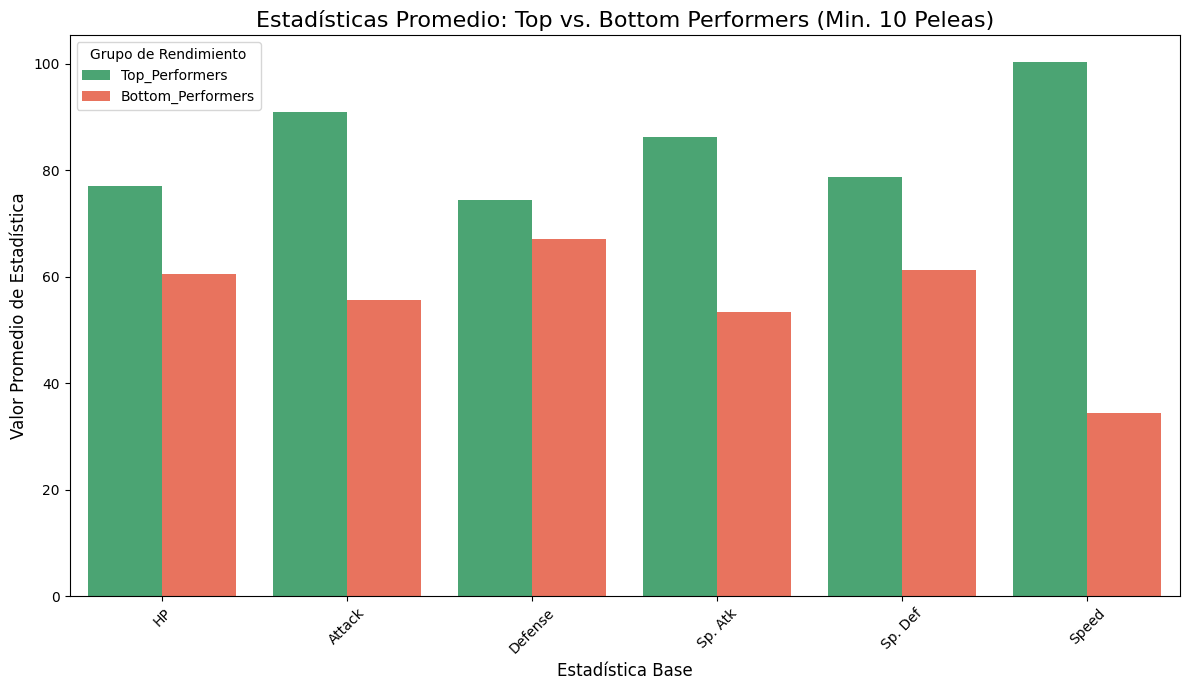

In [12]:
if not top_winners.empty and not bottom_losers.empty:
    avg_stats_top = top_winners[STATS_COLS].mean().rename('Top_Performers')
    avg_stats_bottom = bottom_losers[STATS_COLS].mean().rename('Bottom_Performers')
    
    comparison_df_melted = pd.concat([avg_stats_top, avg_stats_bottom], axis=1).reset_index()
    comparison_df_melted = comparison_df_melted.melt(id_vars='index', var_name='Group', value_name='Average_Stat_Value')
    comparison_df_melted.rename(columns={'index': 'Stat'}, inplace=True)

    plot_average_stats_comparison(
        comparison_df=comparison_df_melted,
        title=f'Estadísticas Promedio: Top vs. Bottom Performers (Min. {MIN_FIGHTS_THRESHOLD} Peleas)',
        ylabel='Valor Promedio de Estadística',
        xlabel='Estadística Base',
        legend_title='Grupo de Rendimiento',
        palette_dict={'Top_Performers': 'mediumseagreen', 'Bottom_Performers': 'tomato'},
        save_path=os.path.join(PATH_IMAGES, 'avg_stats_performers_comparison.png')
    )
else:
    print("No se generó el Gráfico 1: Grupos 'top_winners' o 'bottom_losers' están vacíos o no se definieron.")


In [13]:
# --- Gráfico 2: Distribución de Estadísticas Totales (KDE) ---

Gráfico guardado en: ../images/total_stats_kde_performers_comparison.png


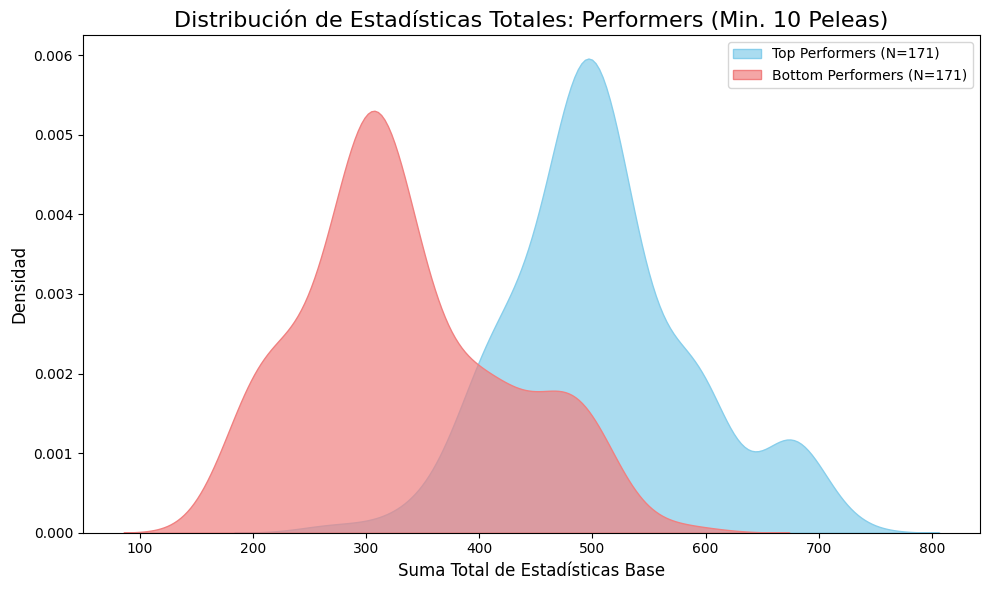

In [14]:
if not top_winners.empty and not bottom_losers.empty:
    numeric_stats_cols_gw = [col for col in STATS_COLS if pd.api.types.is_numeric_dtype(top_winners[col])]
    numeric_stats_cols_bw = [col for col in STATS_COLS if pd.api.types.is_numeric_dtype(bottom_losers[col])]

    if not numeric_stats_cols_gw or not numeric_stats_cols_bw:
        print("ADVERTENCIA: No todas las columnas en STATS_COLS son numéricas en los dataframes de ganadores/perdedores. Verifique STATS_COLS.")
    else:
        top_winners_total_stats = top_winners[numeric_stats_cols_gw].sum(axis=1)
        bottom_losers_total_stats = bottom_losers[numeric_stats_cols_bw].sum(axis=1)

        plot_total_stats_kde_comparison(
            data_group1=top_winners_total_stats,
            data_group2=bottom_losers_total_stats,
            label_group1=f'Top Performers (N={len(top_winners)})',
            label_group2=f'Bottom Performers (N={len(bottom_losers)})',
            title=f'Distribución de Estadísticas Totales: Performers (Min. {MIN_FIGHTS_THRESHOLD} Peleas)',
            xlabel='Suma Total de Estadísticas Base',
            save_path=os.path.join(PATH_IMAGES, 'total_stats_kde_performers_comparison.png')
        )
else:
    print("No se generó el Gráfico 2: Grupos 'top_winners' o 'bottom_losers' están vacíos o no se definieron.")
